# CNN model (with 2+ layers of convolutions) to classify image datasets on Dataset

# PyTorch CNN for CIFAR-10

This script implements a ResNet-based architecture with common techniques
like data augmentation (AutoAugment), SGD with momentum, weight decay,
and the OneCycleLR learning rate scheduler to achieve high accuracy.
Designed to be run on environments like Kaggle with GPU support.

# Initial Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR # Powerful scheduler
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models # To get ResNet
import time
import copy
import os
import matplotlib.pyplot as plt
import numpy as np

## pytorch Version

In [2]:
%matplotlib inline
print(torch.__version__)

2.5.1+cu124


# Configuration

In [3]:
BATCH_SIZE = int(os.environ.get("BATCH_SIZE", 128))
EPOCHS = int(os.environ.get("EPOCHS", 60))
LEARNING_RATE = float(os.environ.get("LEARNING_RATE", 0.1))
WEIGHT_DECAY = float(os.environ.get("WEIGHT_DECAY", 5e-4))
MOMENTUM = 0.9
NUM_WORKERS = int(os.environ.get("NUM_WORKERS", 2))
DATA_DIR = './data'
MODEL_SAVE_PATH = 'best_cifar10_resnet_pytorch.pth'

# Device Setup

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    PIN_MEMORY = True
    print(f"CUDA available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device("cpu")
    PIN_MEMORY = False
    print("CUDA not available. Using CPU.")

CUDA available. Using GPU: Tesla T4


# Dataset

## Data Preparation

In [5]:
print("Setting up data transformations...")
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                 std=[0.2023, 0.1994, 0.2010])

Setting up data transformations...


## Data Augmentation for Training set

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'), # Reflect padding often works well
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10), # Strong augmentation policy
    transforms.ToTensor(),
    normalize,
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False) # Cutout/Random Erasing
])

## Transformation for Validation/Testing set (only normalization)

In [7]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

## Load Dataset

Download and load datasets

Adding exception handling for robustness in different environments

In [8]:
print("Loading CIFAR-10 dataset...")
try:
    train_dataset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transform_test)
    print("Dataset downloaded/loaded successfully.")
except Exception as e:
    print(f"Error during dataset download/load: {e}")
    print("Attempting to load from local directory assuming it exists...")
    try:
        train_dataset = datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=transform_train)
        test_dataset = datasets.CIFAR10(root=DATA_DIR, train=False, download=False, transform=transform_test)
        print("Dataset loaded successfully from local directory.")
    except Exception as e2:
        print(f"Failed to load dataset from local directory: {e2}")
        print("Please ensure the dataset is available or network access is configured.")
        exit() # Exit if dataset cannot be loaded

Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:02<00:00, 59.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataset downloaded/loaded successfully.


# Data Loaders

In [9]:
print("Creating DataLoaders...")
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          persistent_workers=True if NUM_WORKERS > 0 else False) # Can speed up loading

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE*2, # Use larger batch size for evaluation
                         shuffle=False,
                         num_workers=NUM_WORKERS,
                         pin_memory=PIN_MEMORY,
                         persistent_workers=True if NUM_WORKERS > 0 else False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

Creating DataLoaders...
Train dataset size: 50000
Test dataset size: 10000
Number of training batches: 391
Number of testing batches: 40


# Model Definition (ResNet18 adapted for CIFAR-10)

Modify the first convolution layer for 32x32 images:

Original ResNet18's conv1 is kernel_size=7, stride=2, padding=3

We adapt it for smaller images: kernel_size=3, stride=1, padding=1

In [10]:
print("Defining the model architecture (ResNet18 adapted for CIFAR-10)...")
def create_resnet18_cifar():
    """Creates a ResNet-18 model adapted for CIFAR-10 (32x32 input)."""
    model = models.resnet18(weights=None, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

    # Remove the initial max pooling layer (not needed for 32x32)
    # Original ResNet18's maxpool is kernel_size=3, stride=2, padding=1
    model.maxpool = nn.Identity() # Identity layer simply passes input through

    return model

model = create_resnet18_cifar().to(DEVICE)
# print(model) # Uncomment to view the adapted architecture details

Defining the model architecture (ResNet18 adapted for CIFAR-10)...


# Loss Function, Optimizer, Scheduler 

In [11]:
print("Setting up loss function, optimizer, and learning rate scheduler...")
criterion = nn.CrossEntropyLoss()

Setting up loss function, optimizer, and learning rate scheduler...


## Optimizer: SGD with momentum and weight decay is standard for ResNets with OneCycleLR

In [12]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, # Initial LR (OneCycleLR adjusts this)
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True) # Nesterov momentum sometimes helps

## Learning Rate Scheduler: OneCycleLR
Dynamically adjusts LR: increases then decreases. Often leads to faster training and better results.

In [13]:
scheduler = OneCycleLR(optimizer,
                       max_lr=LEARNING_RATE,          # The peak learning rate
                       epochs=EPOCHS,                 # Total number of epochs
                       steps_per_epoch=len(train_loader), # Steps per epoch
                       pct_start=0.3,                 # Percentage of cycle increasing LR (default 0.3)
                       anneal_strategy='cos',         # Cosine annealing (default)
                       div_factor=10,                 # Determines initial LR (max_lr / div_factor)
                       final_div_factor=100)          # Determines final LR (initial_lr / final_div_factor)

# Training and Validation Functions 

In [14]:
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device): # Add scaler if using AMP
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    start_epoch_time = time.time()

    for i, (inputs, labels) in enumerate(train_loader):
        batch_start_time = time.time()
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True) # Use non_blocking for potential speedup

        optimizer.zero_grad(set_to_none=True) # More memory efficient than zeroing

        # --- Standard Precision Training ---
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # --- End Standard Precision Block ---


        # Step the scheduler *after* the optimizer step
        scheduler.step()

        # --- Statistics ---
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Print progress occasionally
        if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
            current_lr = optimizer.param_groups[0]['lr'] # Get current LR
            batch_time = time.time() - batch_start_time
            print(f'\r  Batch [{i+1:>4}/{len(train_loader):<4}] | Loss: {loss.item():.4f} | LR: {current_lr:.6f} | Time: {batch_time*1000:.1f}ms', end='')

    print() # Newline after epoch progress
    epoch_duration = time.time() - start_epoch_time
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f"  Epoch Train Duration: {epoch_duration:.2f}s")
    return epoch_loss, epoch_acc

def validate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    val_start_time = time.time()

    with torch.no_grad():  # Essential for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # --- Standard Precision ---
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # --- End Standard Precision ---

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    val_duration = time.time() - val_start_time
    print(f"  Validation Duration: {val_duration:.2f}s")
    return epoch_loss, epoch_acc

# Main Training Loop 

In [15]:
print(f"\n--- Starting Training for {EPOCHS} Epochs ---")
start_train_time = time.time()

best_val_accuracy = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, DEVICE) # Pass scaler if using AMP

    # Validate
    val_loss, val_acc = validate(model, test_loader, criterion, DEVICE)

    # Log history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr']) # Log LR at end of epoch

    epoch_duration = time.time() - epoch_start_time
    print("-" * 50)
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Valid Loss: {val_loss:.4f} | Valid Acc: {val_acc*100:.2f}%")
    print(f"  Epoch Duration: {epoch_duration:.2f}s")
    print("-" * 50)

    # Save the model checkpoint if validation accuracy improves
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        # Save the model's state dictionary
        try:
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"  ** Checkpoint Saved: {MODEL_SAVE_PATH} (Val Acc: {best_val_accuracy*100:.2f}%) **")
        except Exception as e:
            print(f"  Warning: Could not save model checkpoint. Error: {e}")


total_train_time = time.time() - start_train_time
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {total_train_time / 60:.2f} minutes ({total_train_time:.2f} seconds)")
print(f"Best Validation Accuracy Achieved: {best_val_accuracy*100:.2f}%")


--- Starting Training for 60 Epochs ---

--- Epoch 1/60 ---
  Batch [ 391/391 ] | Loss: 1.5193 | LR: 0.010684 | Time: 63.9ms
  Epoch Train Duration: 40.61s
  Validation Duration: 2.63s
--------------------------------------------------
Epoch 1 Summary:
  Train Loss: 1.7385 | Train Acc: 36.72%
  Valid Loss: 1.3172 | Valid Acc: 53.78%
  Epoch Duration: 43.24s
--------------------------------------------------
  ** Checkpoint Saved: best_cifar10_resnet_pytorch.pth (Val Acc: 53.78%) **

--- Epoch 2/60 ---
  Batch [ 391/391 ] | Loss: 1.0480 | LR: 0.012715 | Time: 67.5ms
  Epoch Train Duration: 42.51s
  Validation Duration: 2.84s
--------------------------------------------------
Epoch 2 Summary:
  Train Loss: 1.2803 | Train Acc: 54.17%
  Valid Loss: 1.0178 | Valid Acc: 64.80%
  Epoch Duration: 45.35s
--------------------------------------------------
  ** Checkpoint Saved: best_cifar10_resnet_pytorch.pth (Val Acc: 64.80%) **

--- Epoch 3/60 ---
  Batch [ 391/391 ] | Loss: 0.9895 | LR: 0.01

# Final Evaluation on Test Set 

In [16]:
print(f"\nLoading best model from '{MODEL_SAVE_PATH}' for final evaluation...")
try:
    best_model = create_resnet18_cifar().to(DEVICE)
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE)) # Ensure map_location for CPU fallback

    test_loss, test_acc = validate(best_model, test_loader, criterion, DEVICE)
    print(f"\n--- Final Test Set Performance (Best Model) ---")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc*100:.2f}%")
except FileNotFoundError:
    print(f"Error: Best model file '{MODEL_SAVE_PATH}' not found. Skipping final evaluation.")
except Exception as e:
     print(f"Error loading best model or during final evaluation: {e}")


Loading best model from 'best_cifar10_resnet_pytorch.pth' for final evaluation...


/tmp/ipykernel_19/2520596602.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE)) # Ensure map_lo

  Validation Duration: 3.02s

--- Final Test Set Performance (Best Model) ---
  Test Loss: 0.1452
  Test Accuracy: 95.20%


# Plotting Training History


Generating training history plots...
Training history plot saved as 'training_history_pytorch.png'

--- Script Finished ---


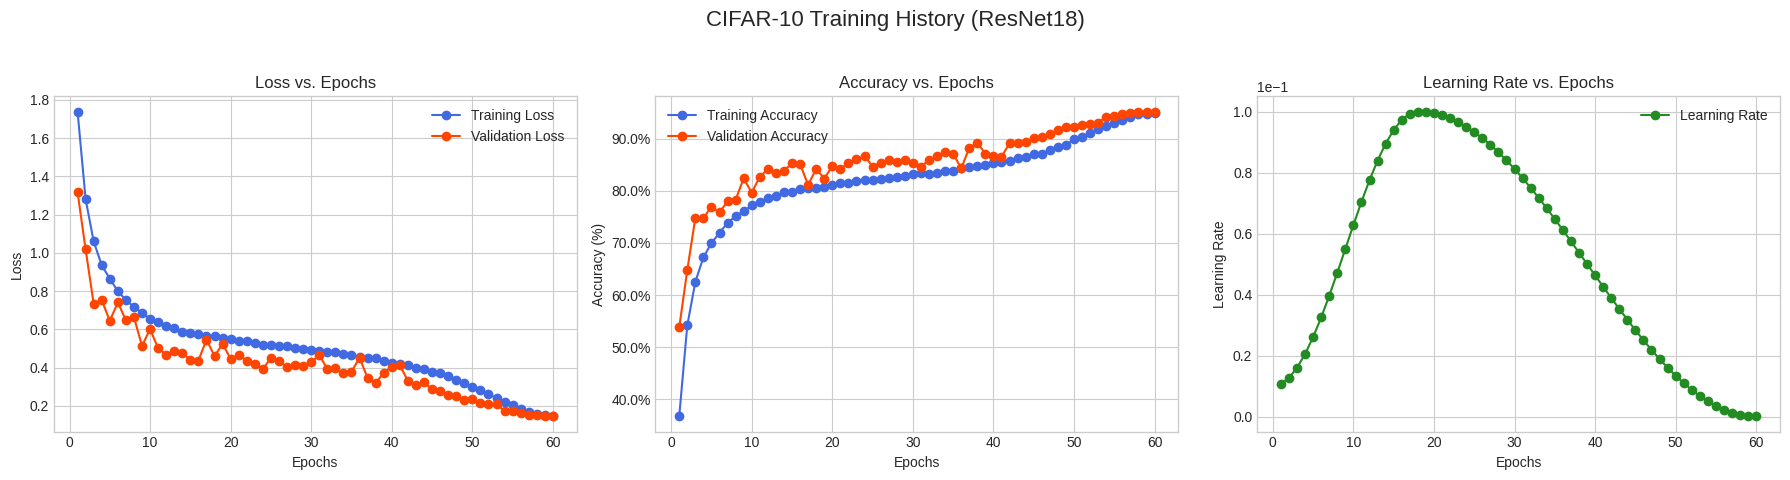

In [17]:
print("\nGenerating training history plots...")
def plot_training_history(history):
    epochs_range = range(1, len(history['train_loss']) + 1)
    plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style

    fig, axs = plt.subplots(1, 3, figsize=(18, 5)) # Create 3 subplots

    # Plot Loss
    axs[0].plot(epochs_range, history['train_loss'], 'o-', color='royalblue', label='Training Loss')
    axs[0].plot(epochs_range, history['val_loss'], 'o-', color='orangered', label='Validation Loss')
    axs[0].set_title('Loss vs. Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(epochs_range, [acc * 100 for acc in history['train_acc']], 'o-', color='royalblue', label='Training Accuracy')
    axs[1].plot(epochs_range, [acc * 100 for acc in history['val_acc']], 'o-', color='orangered', label='Validation Accuracy')
    axs[1].set_title('Accuracy vs. Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%')) # Format y-axis as percentage

    # Plot Learning Rate
    axs[2].plot(epochs_range, history['lr'], 'o-', color='forestgreen', label='Learning Rate')
    axs[2].set_title('Learning Rate vs. Epochs')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Learning Rate')
    axs[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Use scientific notation if needed
    axs[2].legend()

    fig.suptitle('CIFAR-10 Training History (ResNet18)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.savefig('training_history_pytorch.png') # Save the plot
    print("Training history plot saved as 'training_history_pytorch.png'")
    # plt.show() # Display the plot if running interactively

# Check if history has data before plotting
if history['train_loss']:
    plot_training_history(history)
else:
    print("No training history recorded, skipping plot generation.")

print("\n--- Script Finished ---")